# Time course growth and substrate  data ➟ Growth parameters
This notebook calculates the growth rate, yield coefficient, and substrate uptake rate of R. opacus cultures growing with phenol and glucose. These experiements were published in these papers: [Yondeda (2016)](https://academic.oup.com/nar/article/44/5/2240/2465306) and [Henson (2018)](https://www.sciencedirect.com/science/article/pii/S1096717618300910).

#### Yoneda data:
* WT 1.5 g/L Phenol (3 trials)
* Evol33 1.5 g/L Phenol (3 trials)
* Evol40 1.5 g/L Phenol (3 trials)
<br><br>
* WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate (1 trial)
* Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate (1 trial)
* Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate (1 trial)
<br><br>
* WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate (1 trial)
* Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate (1 trial)
* Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate (1 trial)

#### Henson data:
* WT 0.5 g/L Phenol (3 trials)
* PVHG6 0.5 g/L Phenol (3 trials)

### Method: 
<ol>
<li>Calculate growth rate by finding slope of log(biomass) vs. time</li>
<li>Simulate biomass growth by using timepoints and X = X0e^(mu*t)</li>
<li>Calculate yield coefficient by finding the slope of the biomass generated vs substrate consumed</li>
<li>Calculate substrate uptake rate by dividing the growth rate by the yield coefficient</li>
</ol>

### Notes:
The glucose concentration measurements in the Yoneda data sets seem unrealistically low


### Setup imports

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
from scipy import mean

# TODO: Add a supplementary info scatter plot showing this. 
GRAMS_BIOMASS_PER_LITER_PER_OD = 0.35 # 1 OD = 0.35 g/L of biomass

### Define functions to calculate growth rate, yield coefficient, and substrate uptake rate

stats_for_trial: Calculates parameters and plots data and fit lines for a single trial
<br>
stats_for_condition: Takes in three trial names and calls stats_for_trial for each one.

In [2]:
def stats_for_trial(growth_data, substrate_data, molar_mass, display=False, max_time=0, substrate=''):
    
    biomass_values = growth_data['Biomass Conc']
    biomass_times = growth_data['Time']
    biomass_init = list(biomass_values)[0]

    substrate_values = substrate_data['Value']*1000/molar_mass
    substrate_times = substrate_data['Time']
    substrate_init = list(substrate_values)[0]
    
    # growth is the slope of log(biomass) vs. time
    growth_rate, _, _, _, _ = linregress(biomass_times, [math.log(val) for val in biomass_values])
    
    # biomass X = X0*e^(μ*t)
    # This is different from above to ensure that there is a biomass value for every substrate measurement
    biomass_sim = [biomass_init*math.exp(growth_rate*time) for time in substrate_times]
    
    # actual consumption = S0 - S
    sub_consumed = [substrate_init - sub_value for sub_value in substrate_values]
    
    # new biomass X = X0 - X
    biomass_sim_growth = [sim_value - biomass_init for sim_value in biomass_sim ]
    
    # yield is the amount of biomass that can be made from a mmol of substrate
    yield_coeff, _, _, _, _ = linregress(sub_consumed, biomass_sim_growth)

    # S = S0 - (1/yield)*X
    substrate_sim = [substrate_init - 1/yield_coeff*val for val in biomass_sim_growth]
    
    substrate_consumption_rate = (1/yield_coeff) * growth_rate

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    axes[0].plot(biomass_times, biomass_values, 'o', color='black')
    axes[0].plot(substrate_times, biomass_sim, '-', color='black')
    axes[1].plot(substrate_times, substrate_values, 'o', color='blue')
    axes[1].plot(substrate_times, substrate_sim, '-', color='blue')
    axes[0].set_title('Biomass growth')
    axes[1].set_title(f'{substrate} consumption')
    axes[0].set_xlabel('Time (hr)')
    axes[1].set_xlabel('Time (hr)')
    axes[0].set_ylabel('Biomass (g/L)')
    axes[1].set_ylabel(f'{substrate} (mmol/L)')
    fig.tight_layout()
    
    if display:
        print(f'growth_rate = {growth_rate:.3f} hr-1')
        print(f'yield coefficient = {yield_coeff:.3f} g biomass / mmol substrate')
        print(f'substrate consumption rate = {substrate_consumption_rate:.3f} mmol substrate/gram biomass * hr')
    else:
        return growth_rate, yield_coeff, substrate_consumption_rate
    
def stats_for_condtion(od_df, sub_df, trial_1, trial_2, trial_3, molar_mass, substrate='', max_time=0):
    
    if max_time != 0:
        od_df = od_df[od_df['Time'] < max_time]
        sub_df = sub_df[sub_df['Time'] < max_time]
        
    od_1 = od_df[od_df['Line Name'] == trial_1]
    sub_1 = sub_df[sub_df['Line Name'] == trial_1]

    od_2 = od_df[od_df['Line Name'] == trial_2]
    sub_2 = sub_df[sub_df['Line Name'] == trial_2]

    od_3 = od_df[od_df['Line Name'] == trial_3]
    sub_3 = sub_df[sub_df['Line Name'] == trial_3]

    gr_1, yc_1, scr_1 = stats_for_trial(od_1, sub_1, molar_mass, substrate=substrate)
    gr_2, yc_2, scr_2 = stats_for_trial(od_2, sub_2, molar_mass, substrate=substrate)
    gr_3, yc_3, scr_3 = stats_for_trial(od_3, sub_3, molar_mass, substrate=substrate)

    print(f'growth_rate = {np.average([gr_1, gr_2, gr_3]):.3f} ± {np.std([gr_1, gr_2, gr_3]):.3f} hr-1')
    print(f'yield coefficient = {np.average([yc_1, yc_2, yc_3]):.3f} ± {np.std([yc_1, yc_2, yc_3]):.3f} g biomass / mmol substrate')
    print(f'substrate consumption rate = {np.average([scr_1, scr_2, scr_3]):.3f} ± {np.std([scr_1, scr_2, scr_3]):.3f} mmol substrate/gram biomass * hr')

### Load Yoneda  growth curves

In [3]:
od_filename = '../../EDD_Yoneda_data/Yoneda_set2_ODD_data.csv'
substrate_filename = '../../EDD_Yoneda_data/Yoneda_set2_Metabolomics_data.csv'

od_df = pd.read_csv(od_filename)
sub_df = pd.read_csv(substrate_filename)

od_df['Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_df['Value']

print(f'substrate data has {len(sub_df)} lines')
print(f'OD data has {len(od_df)} lines')

substrate data has 84 lines
OD data has 63 lines


### Yoneda: WT 1.5 g/L Phenol

growth_rate = 0.019 ± 0.001 hr-1
yield coefficient = 0.027 ± 0.003 g biomass / mmol substrate
substrate consumption rate = 0.703 ± 0.033 mmol substrate/gram biomass * hr


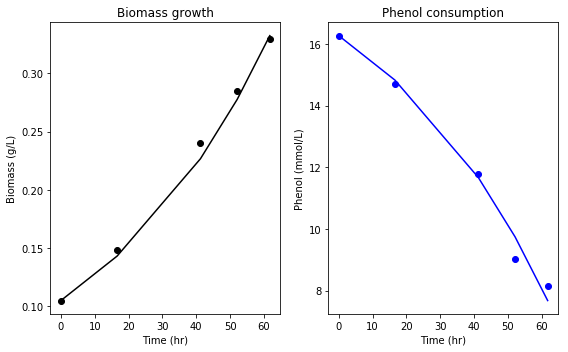

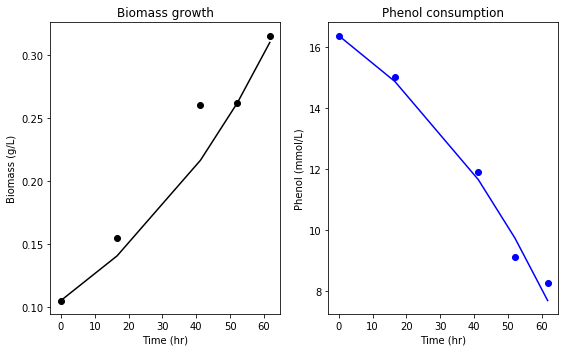

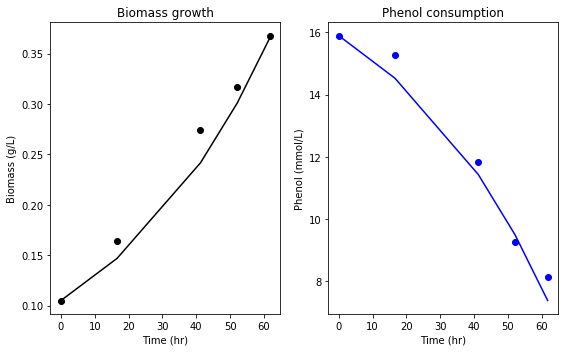

In [4]:
stats_for_condtion(od_df, sub_df, 'WT-R1', 'WT-R2', 'WT-R3', 94.11, substrate='Phenol')

### Yoneda: Evol33 1.5 g/L Phenol

growth_rate = 0.034 ± 0.002 hr-1
yield coefficient = 0.033 ± 0.002 g biomass / mmol substrate
substrate consumption rate = 1.014 ± 0.021 mmol substrate/gram biomass * hr


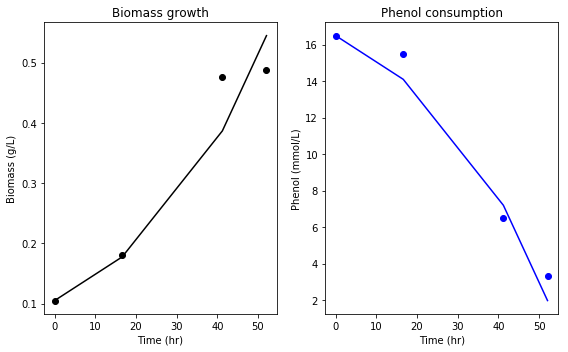

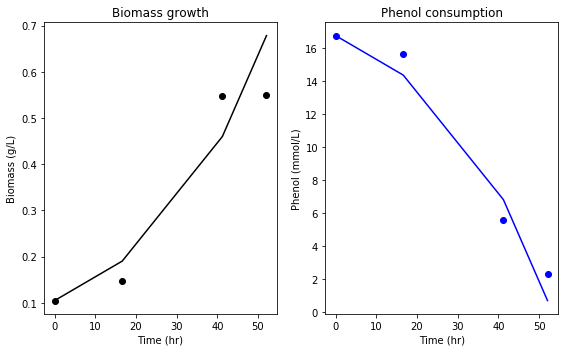

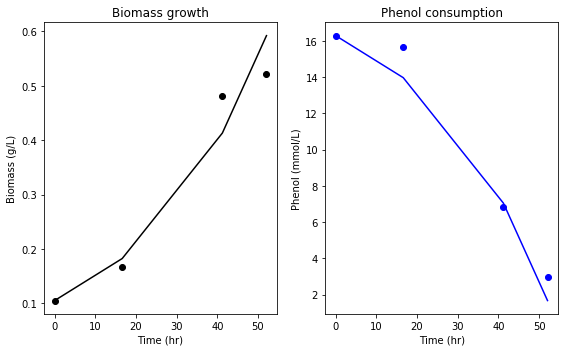

In [5]:
stats_for_condtion(od_df, sub_df, 'EVOL33-R1', 'EVOL33-R2', 'EVOL33-R3', 94.11, substrate='Phenol', max_time=60)

### Yoneda: Evol40 1.5 g/L Phenol

growth_rate = 0.034 ± 0.001 hr-1
yield coefficient = 0.036 ± 0.002 g biomass / mmol substrate
substrate consumption rate = 0.943 ± 0.030 mmol substrate/gram biomass * hr


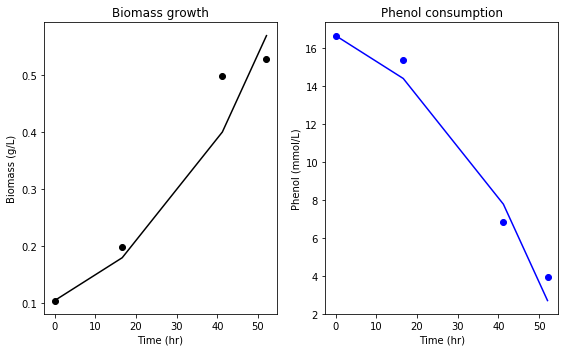

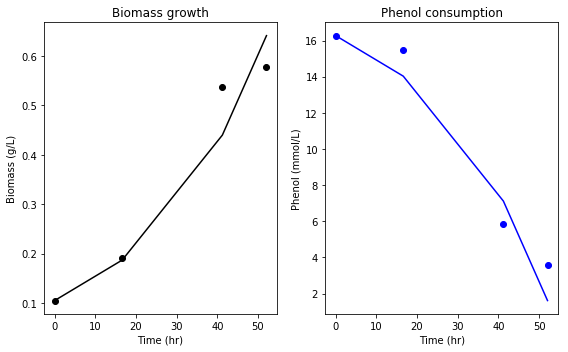

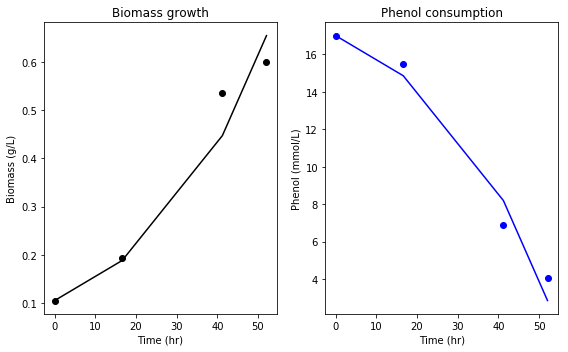

In [6]:
stats_for_condtion(od_df, sub_df, 'EVOL40-R1', 'EVOL40-R2', 'EVOL40-R3', 94.11, substrate='Phenol', max_time=60)

### Yoneda: WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate

growth_rate = 0.032 hr-1
yield coefficient = 1.150 g biomass / mmol substrate
substrate consumption rate = 0.027 mmol substrate/gram biomass * hr


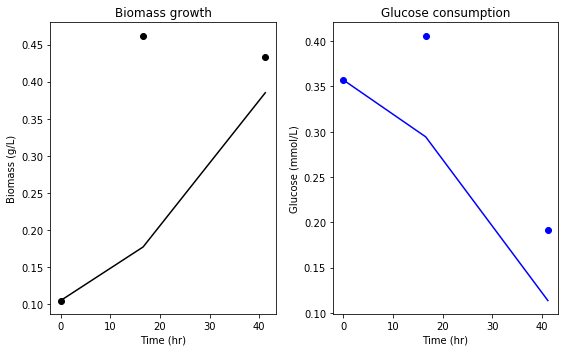

In [7]:
od_1 = od_df[od_df['Line Name'] == 'WT-G']
sub_1 = sub_df[sub_df['Line Name'] == 'WT-G']

stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

### Yoneda: Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate

growth_rate = 0.031 hr-1
yield coefficient = 0.726 g biomass / mmol substrate
substrate consumption rate = 0.043 mmol substrate/gram biomass * hr


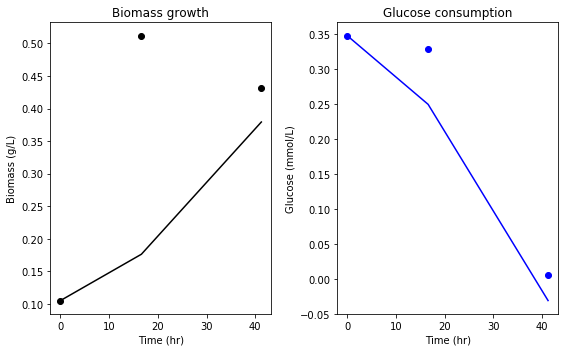

In [8]:
od_1 = od_df[od_df['Line Name'] == 'EVOL33-G']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL33-G']
stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

### Yoneda: Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate

growth_rate = 0.031 hr-1
yield coefficient = -0.500 g biomass / mmol substrate
substrate consumption rate = -0.063 mmol substrate/gram biomass * hr


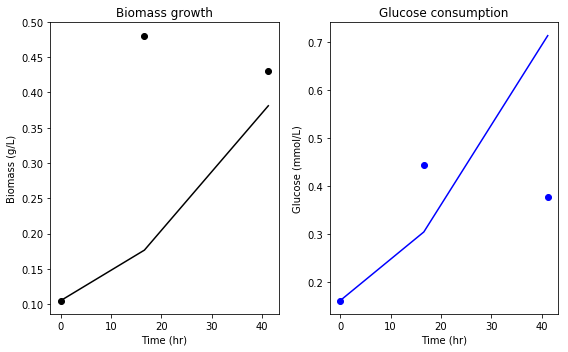

In [9]:
od_1 = od_df[od_df['Line Name'] == 'EVOL40-G']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL40-G']
stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

### Yoneda: WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate

growth_rate = 0.039 hr-1
yield coefficient = 1.834 g biomass / mmol substrate
substrate consumption rate = 0.021 mmol substrate/gram biomass * hr


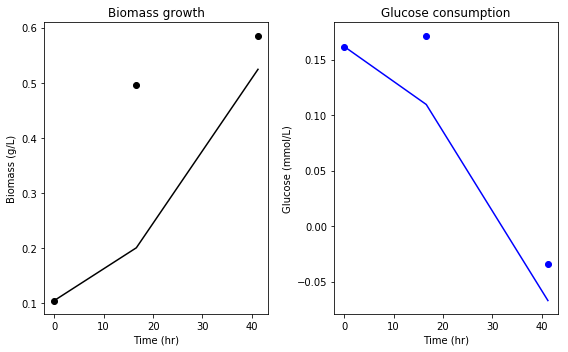

In [10]:
od_1 = od_df[od_df['Line Name'] == 'WT-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'WT-G-N']
stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

### Yoneda: Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate

growth_rate = 0.033 hr-1
yield coefficient = 1.006 g biomass / mmol substrate
substrate consumption rate = 0.033 mmol substrate/gram biomass * hr


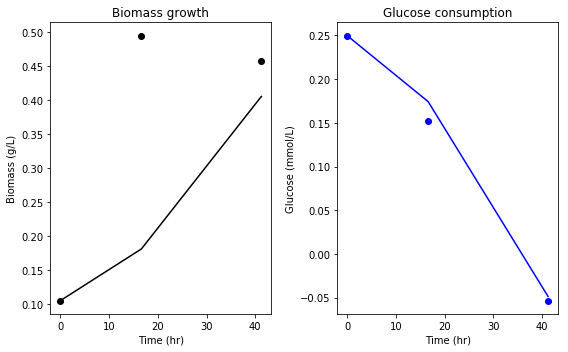

In [11]:
od_1 = od_df[od_df['Line Name'] == 'EVOL33-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL33-G-N']
stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

### Yoneda: Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate

growth_rate = 0.034 hr-1
yield coefficient = 2.029 g biomass / mmol substrate
substrate consumption rate = 0.017 mmol substrate/gram biomass * hr


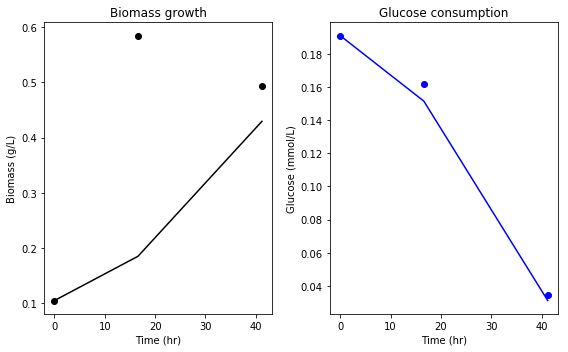

In [12]:
od_1 = od_df[od_df['Line Name'] == 'EVOL40-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL40-G-N']
stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

## Load Henson Data

In [13]:
od_filename = '../../EDD_Henson_data/Henson_ODD_data.csv'
substrate_filename = '../../EDD_Henson_data/Henson_metabolomics_data.csv'

od_df = pd.read_csv(od_filename)
sub_df = pd.read_csv(substrate_filename)

od_df['Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_df['Value']

print(f'substrate data has {len(sub_df)} lines')
print(f'OD data has {len(od_df)} lines')

substrate data has 48 lines
OD data has 60 lines


### Henson: WT 0.5 g/L Phenol

growth_rate = 0.065 ± 0.001 hr-1
yield coefficient = 0.046 ± 0.005 g biomass / mmol substrate
substrate consumption rate = 1.422 ± 0.129 mmol substrate/gram biomass * hr


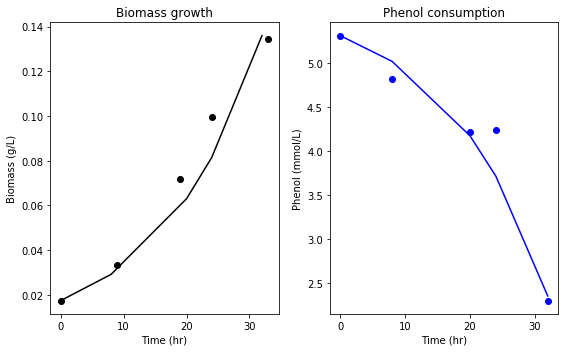

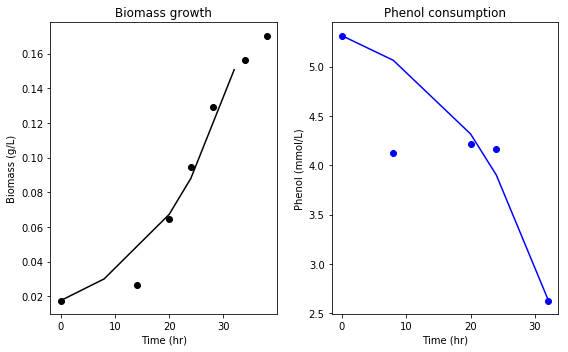

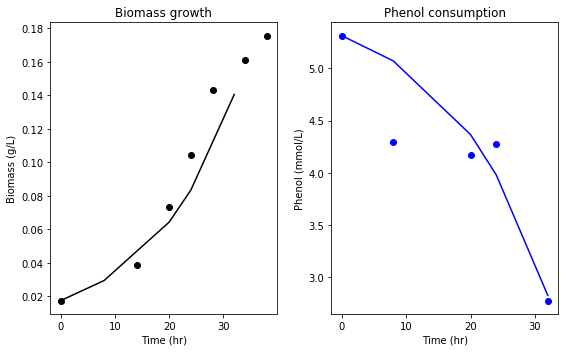

In [14]:
stats_for_condtion(od_df, sub_df,'WT-P-R1', 'WT-P-R2', 'WT-P-R3', 94.11, substrate='Phenol' ,max_time = 40)

### Henson: PVHG6 0.5 g/L Phenol

growth_rate = 0.080 ± 0.003 hr-1
yield coefficient = 0.039 ± 0.002 g biomass / mmol substrate
substrate consumption rate = 2.069 ± 0.023 mmol substrate/gram biomass * hr


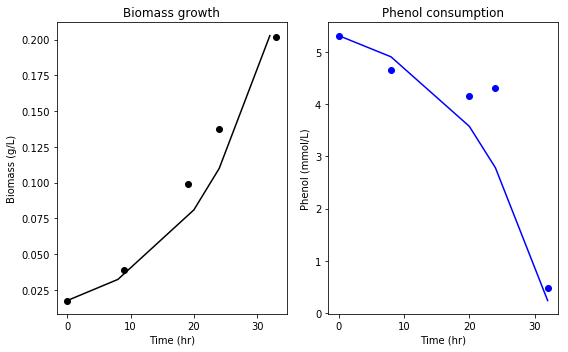

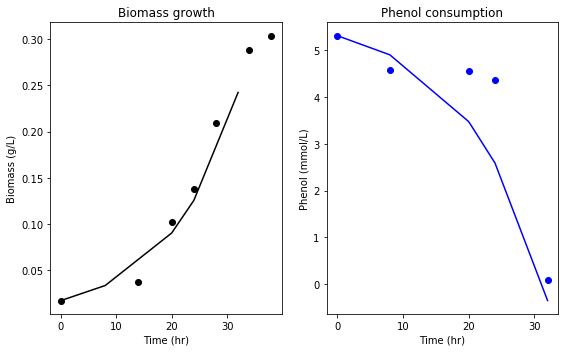

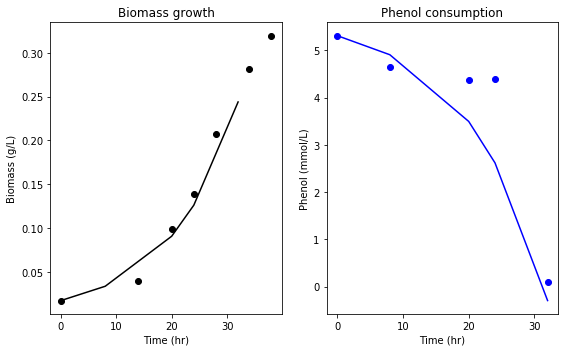

In [15]:
stats_for_condtion(od_df, sub_df, 'PVHG6-P-R1', 'PVHG6-P-R2', 'PVHG6-P-R3', 94.11, substrate='Phenol', max_time=40)

### Glucose 2018 data

In [16]:
od_filename = '../../EDD_glucose_2018_data/2018_OD_data.csv'
substrate_filename = '../../EDD_glucose_2018_data/2018_metabolomics_data.csv'

od_df = pd.read_csv(od_filename)
sub_df = pd.read_csv(substrate_filename)

od_df['Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_df['Value']

print(f'substrate data has {len(sub_df)} lines')
print(f'OD data has {len(od_df)} lines')

substrate data has 12 lines
OD data has 12 lines


growth_rate = 0.260 ± 0.005 hr-1
yield coefficient = 0.069 ± 0.004 g biomass / mmol substrate
substrate consumption rate = 3.767 ± 0.149 mmol substrate/gram biomass * hr


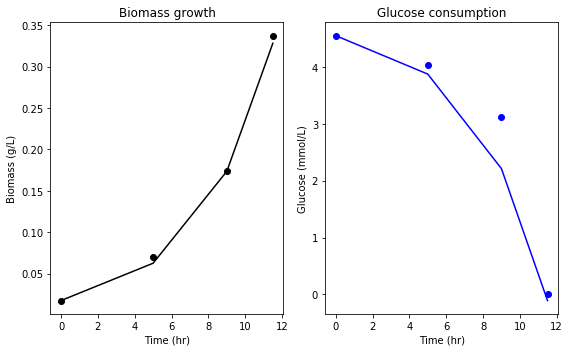

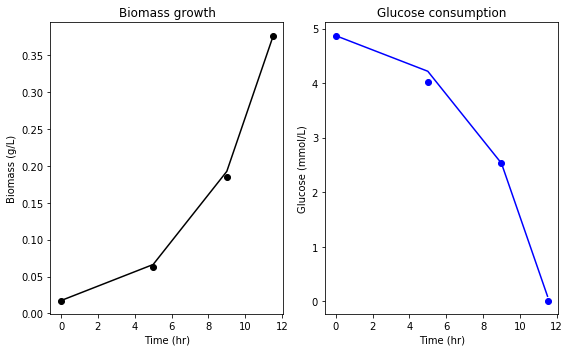

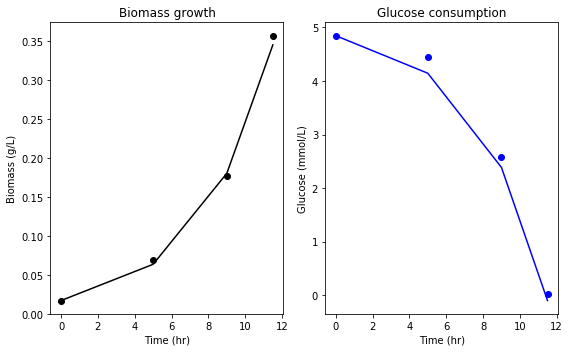

In [17]:
stats_for_condtion(od_df, sub_df, 'WT-R1', 'WT-R2', 'WT-R3', 180.16, substrate='Glucose', max_time=12)

### Save findings from this notebook as a csv

In [18]:
data = {
    'Yoneda WT 1.5 g/L Phenol':     [0.703, 0.033, 0.019, 0.001, 0.027, 0.003], 
    'Yoneda Evol33 1.5 g/L Phenol': [1.014, 0.021, 0.034, 0.002, 0.033, 0.002 ],
    'Yoneda Evol40 1.5 g/L Phenol': [0.943, 0.030, 0.034, 0.001, 0.036, 0.002 ],
    
    'Yoneda WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate':     [0.027, 0.000, 0.032, 0.000, 1.150, 0.000 ],
    'Yoneda Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate': [0.043, 0.000, 0.031, 0.000, 0.726, 0.000 ],
    'Yoneda Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate': [-0.063, 0.000, 0.031, 0.000, -0.500, 0.000 ],
    
    'Yoneda WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate':     [0.021, 0.000, 0.039, 0.000, 1.834, 0.000 ],
    'Yoneda Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate': [0.033, 0.000, 0.033, 0.000, 1.006, 0.000 ],
    'Yoneda Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate': [0.017, 0.000, 0.034, 0.000, 2.029, 0.000 ],
    
    'Henson WT 0.5 g/L Phenol':    [1.422, 0.129, 0.065, 0.001, 0.046,0.005 ],
    'Henson PVHG6 0.5 g/L Phenol': [2.069, 0.023, 0.080, 0.003, 0.039,0.002 ],
}


columns = [
    'substrate consumption rate', 
    'substrate consumption rate std dev', 
    'growth rate', 
    'growth rate std dev', 
    'yield coefficient', 
    'yield coefficient std dev'
]

consumption_and_growth_data = pd.DataFrame.from_dict(data, orient='index', columns=columns)

consumption_and_growth_data.to_csv('../consumption_and_growth_data/consumption_and_growth_data.csv')
consumption_and_growth_data

,substrate consumption rate,substrate consumption rate std dev,growth rate,growth rate std dev,yield coefficient,yield coefficient std dev
Yoneda WT 1.5 g/L Phenol,0.703,0.033,0.019,0.001,0.027,0.003
Yoneda Evol33 1.5 g/L Phenol,1.014,0.021,0.034,0.002,0.033,0.002
Yoneda Evol40 1.5 g/L Phenol,0.943,0.030,0.034,0.001,0.036,0.002
"Yoneda WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.027,0.000,0.032,0.000,1.150,0.000
"Yoneda Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.043,0.000,0.031,0.000,0.726,0.000
"Yoneda Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",-0.063,0.000,0.031,0.000,-0.500,0.000
"Yoneda WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.021,0.000,0.039,0.000,1.834,0.000
"Yoneda Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.033,0.000,0.033,0.000,1.006,0.000
"Yoneda Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.017,0.000,0.034,0.000,2.029,0.000
Henson WT 0.5 g/L Phenol,1.422,0.129,0.065,0.001,0.046,0.005
